# HW08: Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

**Functions to optimize**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import timeit
import numba
import cython
from numba import jit, vectorize, float64
from sklearn.datasets import make_blobs

In [2]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

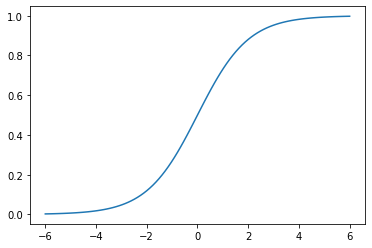

In [3]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [4]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

CPU times: user 1.8 s, sys: 1.03 s, total: 2.83 s
Wall time: 806 ms


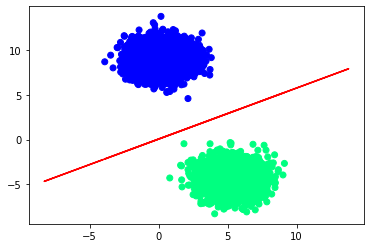

In [5]:
%%time
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [6]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [7]:
def logistic_new(x):
    '''New Logistic Function making one np.exp call'''
    
    return 1 - 1 / (1 + np.exp(x))

In [8]:
%timeit logistic(x)

523 ms ± 8.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit logistic_new(x)

476 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [10]:
@vectorize([float64(float64)])
def logistic_numba_cpu(x):
    '''Logistic Function using vectorization.'''
    return 1 - 1 / (1 + np.exp(x))

@vectorize([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    '''Logistic Function using vectorization and parallelization.'''
    return 1 - 1 / (1 + np.exp(x))

In [11]:
# Calculate the result of logistic(x)
sol = logistic(x)

In [12]:
# Compare logistic(x) and logistic_numba_cpu(x)
np.testing.assert_array_almost_equal(sol, logistic_numba_cpu(x))
%timeit logistic_numba_cpu(x)

254 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
# Compare logistic(x) and logistic_numba_parallel(x)
np.testing.assert_array_almost_equal(sol, logistic_numba_parallel(x))
%timeit logistic_numba_parallel(x)

189 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
@jit('float64[:](float64[:])')
def logistic_numba(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

@jit('float64[:](float64[:,:],float64[:],float64[:],float64,int64)')
def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

<ipython-input-14-e7476a62c04b>:12: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  y_pred = logistic_numba(X @ beta)
<ipython-input-14-e7476a62c04b>:14: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  grad = Xt @ epsilon / n
/home/boyaoli/.local/lib/python3.6/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/boyaoli/.local/lib/python3.6/site-packages/numba/core/typing/npydecl.py:933: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  warnings.warn(NumbaPerformanceWarning(msg))


CPU times: user 984 ms, sys: 703 ms, total: 1.69 s
Wall time: 537 ms


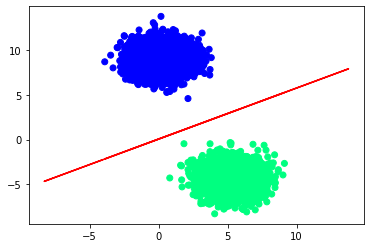

In [15]:
%%time
# Use the same data to compare gd and gd_numba

# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd_numba(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic_numba(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

Based on the result, both gd and gd_numba can seperate two parts of nodes, and gd_numba needs less time.

**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [16]:
%load_ext cython

In [17]:
%%cython -a

import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
cpdef logistic_cython(double[:] x):
    '''Logistic function with cython.'''
    
    cdef int i, k
    k = x.shape[0]
    res = np.zeros(k)
    cdef np.float64_t[:] res_view = res
    cdef np.float64_t exp_x = 0.0
    
    for i in range(k):
        exp_x = exp(x[i])
        res_view[i] = exp_x / (1.0 + exp_x)
    return res

def test_logistic_cython(x):
    res = logistic_cython(x)
    return res

In [18]:
# Test logistic_cython

np.testing.assert_array_almost_equal(sol, test_logistic_cython(x))
%timeit test_logistic_cython(x)

263 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%cython

import cython
import numpy as np
cimport numpy as np
from __main__ import logistic_cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def gd_cython(double[:, :] X, double[:] y, double[:] beta, double alpha, int niter):
    """Gradient algorithm with cython."""
    
    cdef int i, j, k
    cdef int n, p
    cdef double[:] grad
    cdef double[:, :] Xt
    cdef double[:] Xbeta, y_pred
    
    # initialization
    n = X.shape[0]
    p = X.shape[1]
    Xt = np.asarray(X).T
    
    for i in range(niter):
        
        Xbeta = np.zeros(n)
        # calculate X*beta
        for j in range(n):
            for k in range(p):
                Xbeta[j] += X[j, k] * beta[k]
        
        y_pred = logistic_cython(Xbeta)
        
        # calculate Xt*epsilon
        grad = np.zeros(p)
        for j in range(p):
            for k in range(n):
                grad[j] += Xt[j, k] * (y[k] - y_pred[k])
            grad[j] /= n
            beta[j] += alpha * grad[j]        
    
    return beta

In [20]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

CPU times: user 453 ms, sys: 141 ms, total: 594 ms
Wall time: 354 ms


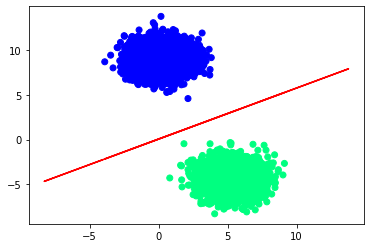

In [21]:
%%time
# Use the same data to compare gd and gd_cython

# initial parameters
niter = 1000
alpha = 0.01
beta = np.zeros(p + 1)

# call gradient descent
beta = gd_cython(X, y, beta, alpha, niter)

# assign labels to points based on prediction
y_pred = logistic_cython(X @ beta)
labels = y_pred > 0.5

# calculate separating plane
sep = (-beta[0] - beta[1] * X)/beta[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

In [22]:
%%file logistic_gd.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <cmath>
#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>

#include <Eigen/LU>

namespace py = pybind11;
using namespace Eigen;

VectorXd logistic(VectorXd xs) {
    return 1 - 1 / (1 + exp(xs.array()));
}

MatrixXd gd(MatrixXd X, VectorXd y, VectorXd beta, double alpha, int niter) {
    
    int i = 0, n, p;
    MatrixXd Xt;
    VectorXd y_pred, epsilon, grad;
    
    n = X.rows();
    p = X.cols();
    Xt = X.transpose();
    y_pred = VectorXd::Zero(n);
    epsilon = VectorXd::Zero(n);
    grad = VectorXd::Zero(p);
    
    for(i = 0; i < niter; i++) {
        y_pred = logistic(X * beta);
        epsilon = y - y_pred;
        grad = Xt * epsilon / n;
        beta += alpha * grad;
    }
    
    return beta;
}
    
PYBIND11_MODULE(logistic_gd, m) {
    m.doc() = "auto-compiled c++ extension";
    m.def("logistic", &logistic);
    m.def("gd", &gd);
}

Overwriting logistic_gd.cpp


In [23]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

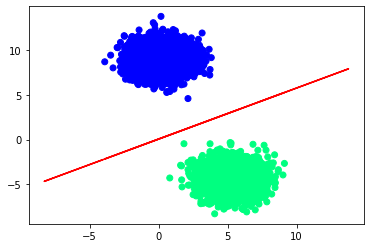

In [24]:
import cppimport
import numpy as np

lgd = cppimport.imp("logistic_gd")
# initial parameters
niter = 1000
alpha = 0.01
beta = np.zeros(p + 1)

# call gradient descent
beta = lgd.gd(X, y, beta, alpha, niter)

# assign labels to points based on prediction
y_pred = lgd.logistic(X @ beta)
labels = y_pred > 0.5

# calculate separating plane
sep = (-beta[0] - beta[1] * X)/beta[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass
